In [12]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [13]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
import models
import torch
from IPython import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Examples of all the functionality

Table of contents:
- Create a maze `venv` and plot it
- Edit the maze interactively using `maze.venv_editor`
- Run the model on the maze for a few timesteps, printing action probabilities using `models.cat_to_human`
- Under the hood: How to programmatically edit maze venv's using the `maze.EnvState` abstraction

### Load a maze env

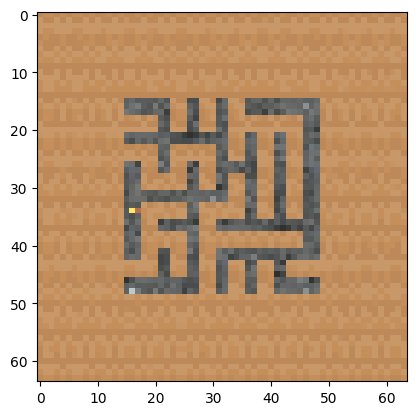

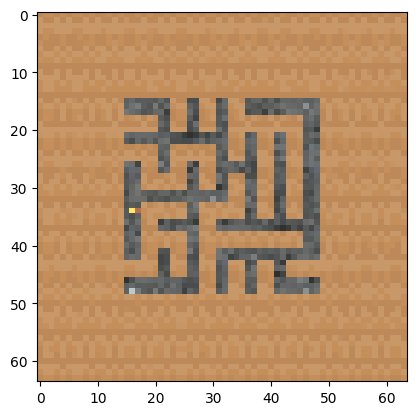

In [14]:
# num is the number of environments to create in the vec env
# num_levels is the number of levels to sample from (0 for infinite, 1 for deterministic)
venv = ProcgenGym3Env(
    num=2, env_name='maze', num_levels=1, start_level=0,
    distribution_mode='hard', num_threads=1, render_mode="rgb_array",
)
venv = maze.wrap_venv(venv)
obs = venv.reset()
# plot all the envs in the vectorized env
for i in range(obs.shape[0]):
    plt.imshow(obs[i].transpose(1, 2, 0))
    plt.show()

## Edit the maze interactively

Using the magic `maze.venv_editor` function!
Clicking in the maze changes walls to empty space and vise versa.
If you click the cheese it'll disappear and reappear where you click next.

**WARNING**: The `venv_editor` updates the `venv`, but after the mouse gets the cheese, the env will reset to its original state.

In [15]:
maze.venv_editor(venv)

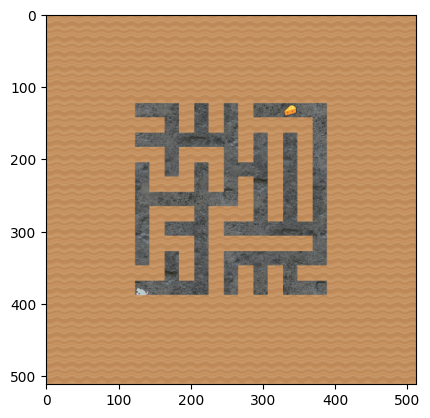

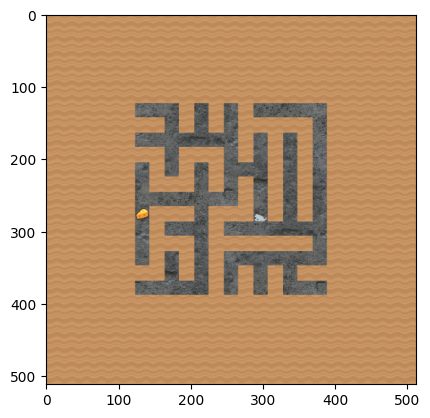

In [16]:
# Verify the venv got updated
info = venv.env.get_info()
for i in range(venv.num_envs):
    # plt.imshow(obs[i].transpose(1, 2, 0))
    plt.imshow(info[i]['rgb'])
    plt.show()

## Run the model on the new maze

In [17]:
if COLAB:
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [18]:
# download from https://drive.google.com/file/d/1db1qJn_ZM49CUcA1k7uSMdsdiAQ4eR5a/view?usp=share_link
policy = models.load_policy('./models/model_rand_region_5.pth', action_size=venv.action_space.n, device=torch.device('cpu'))

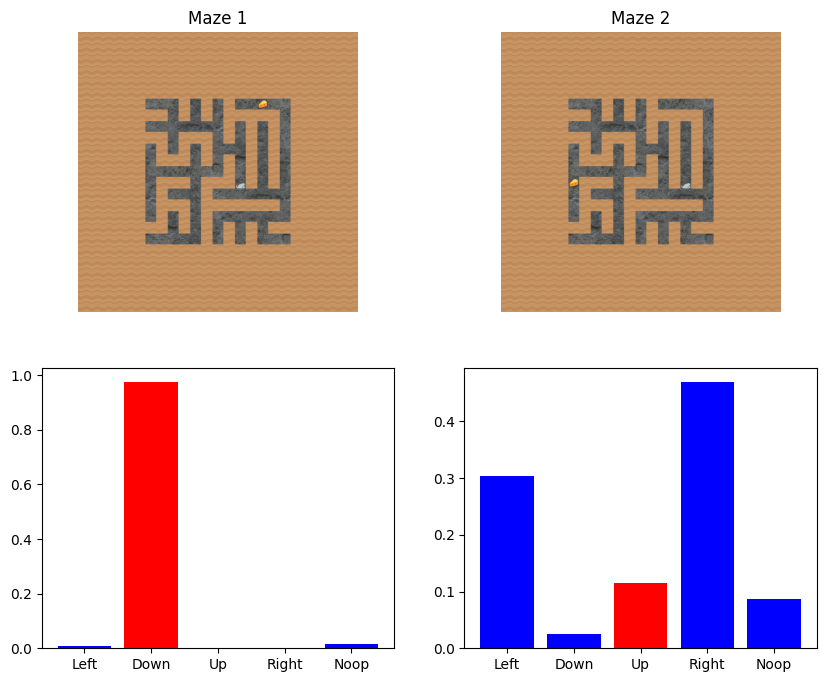

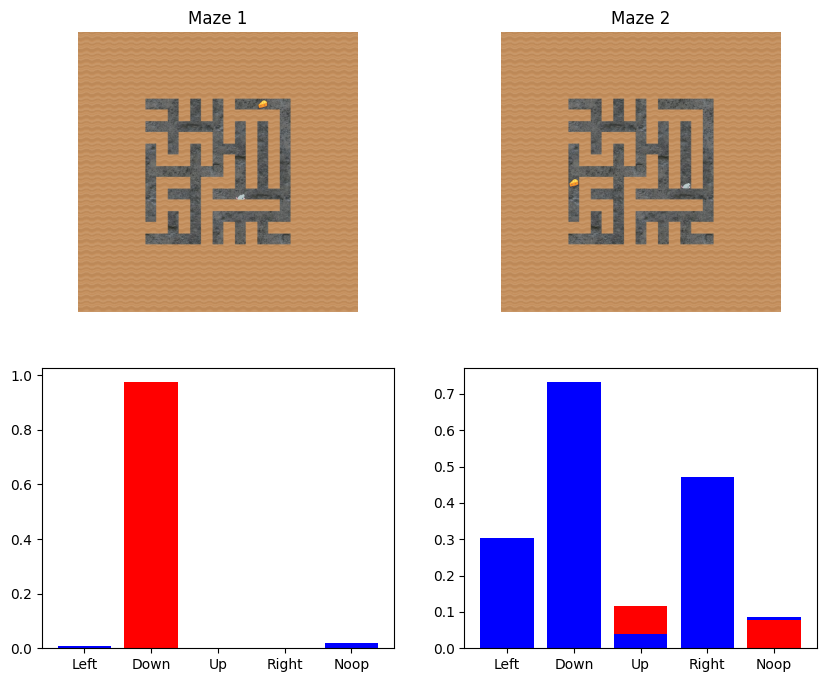

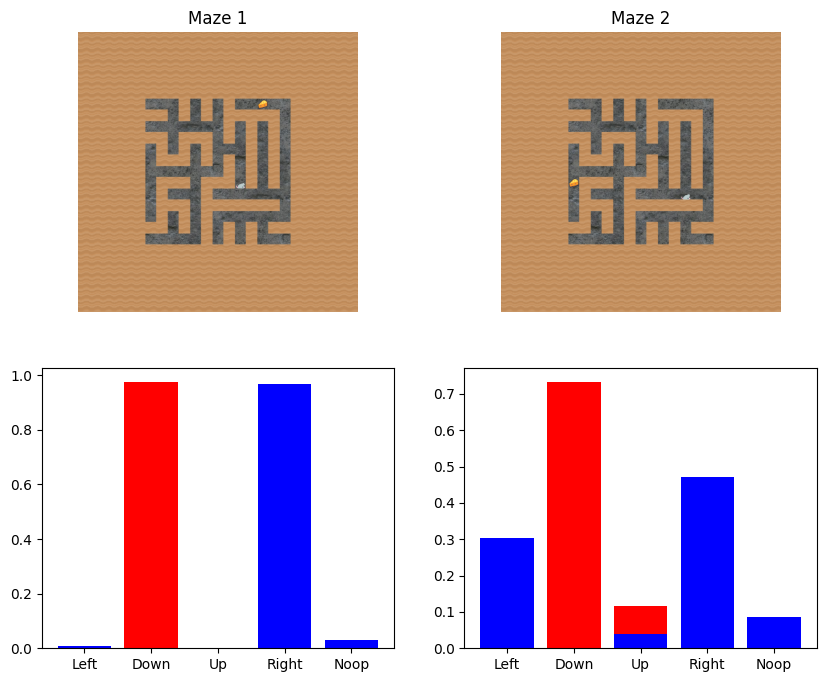

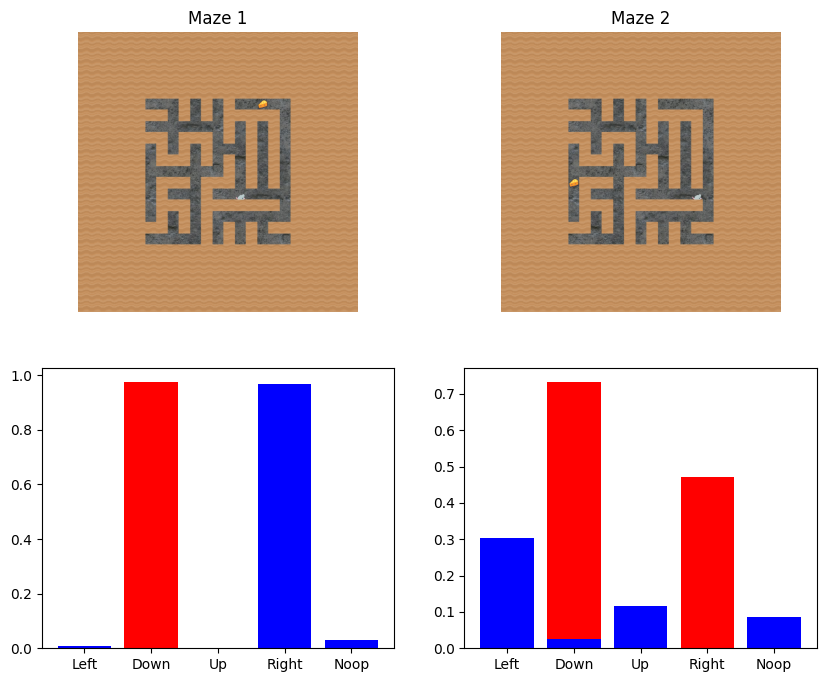

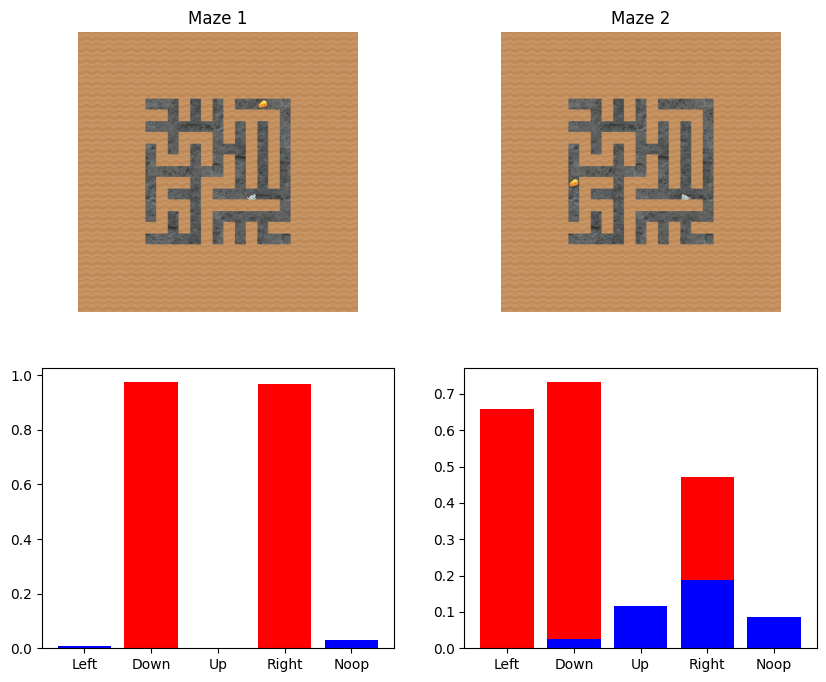

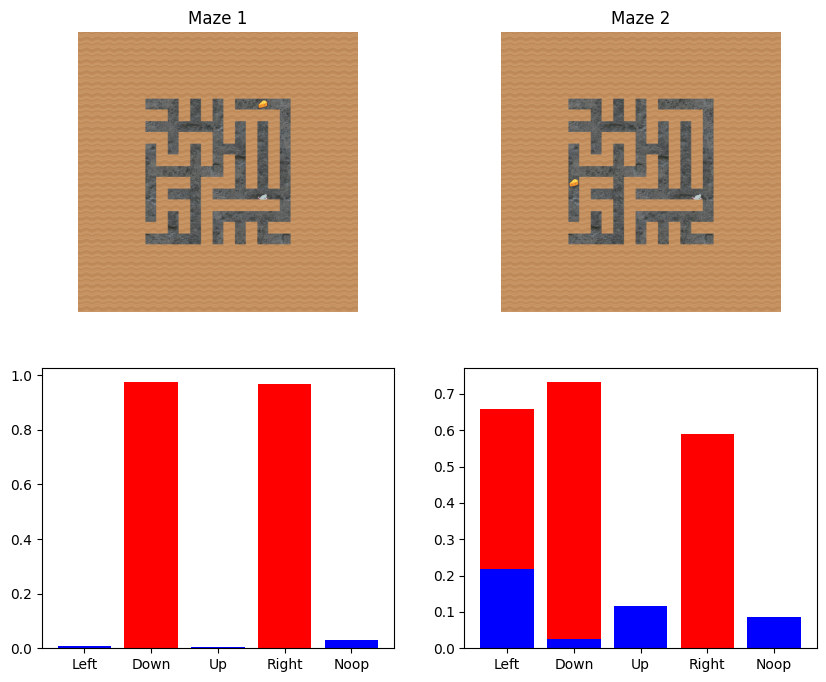

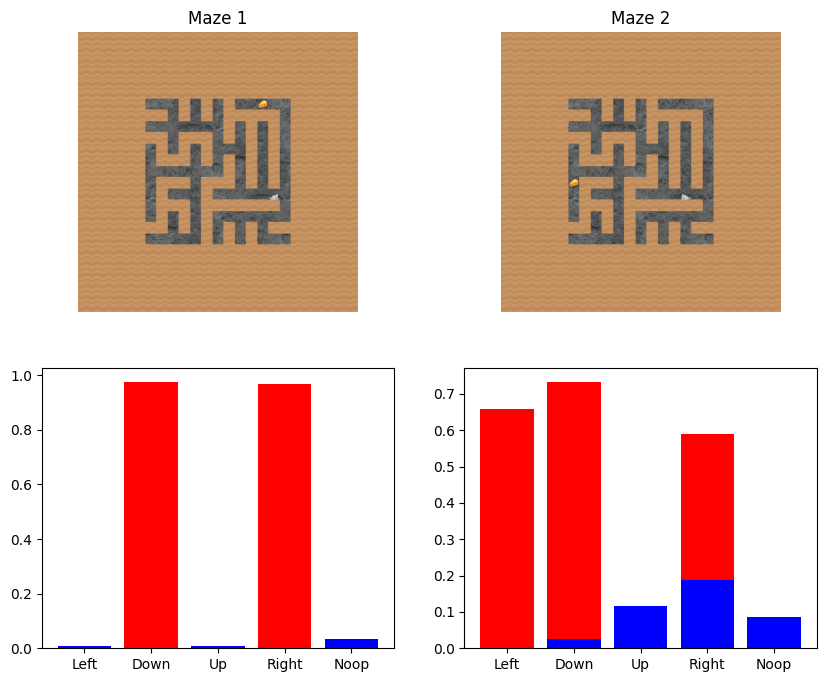

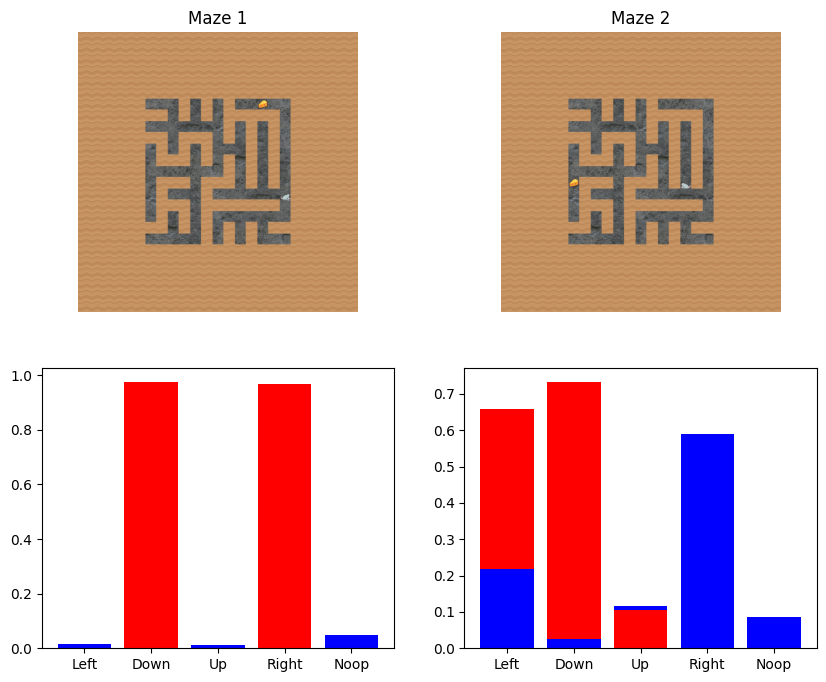

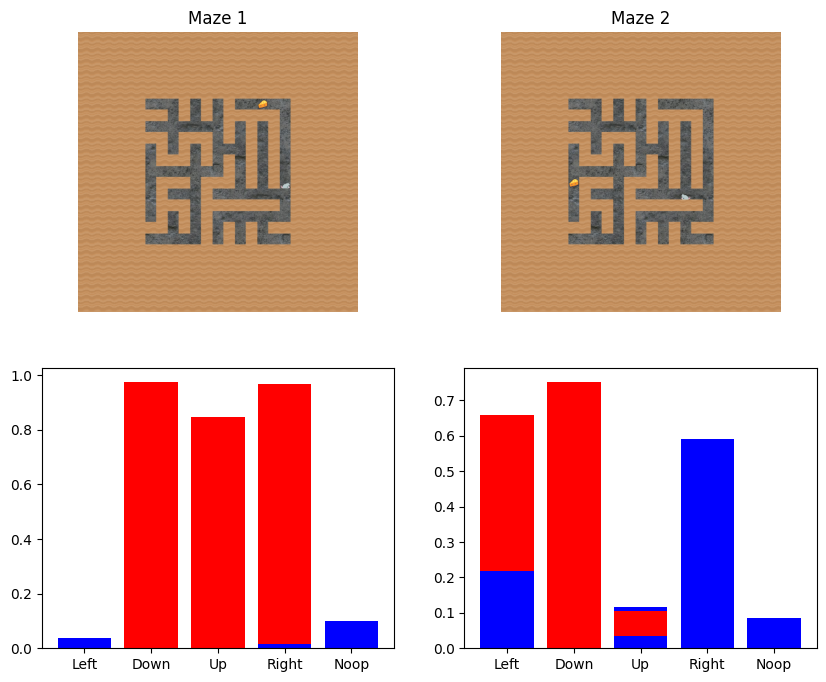

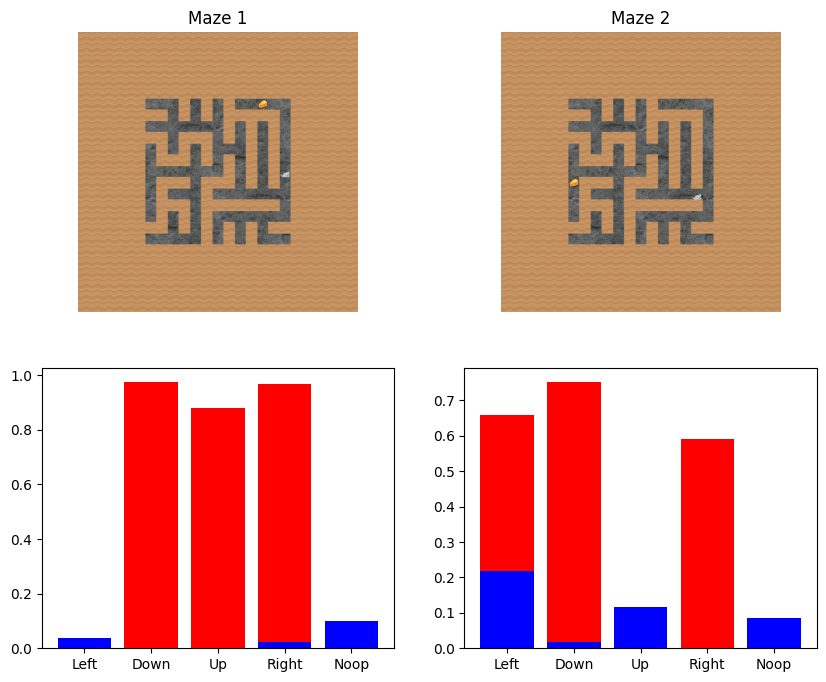

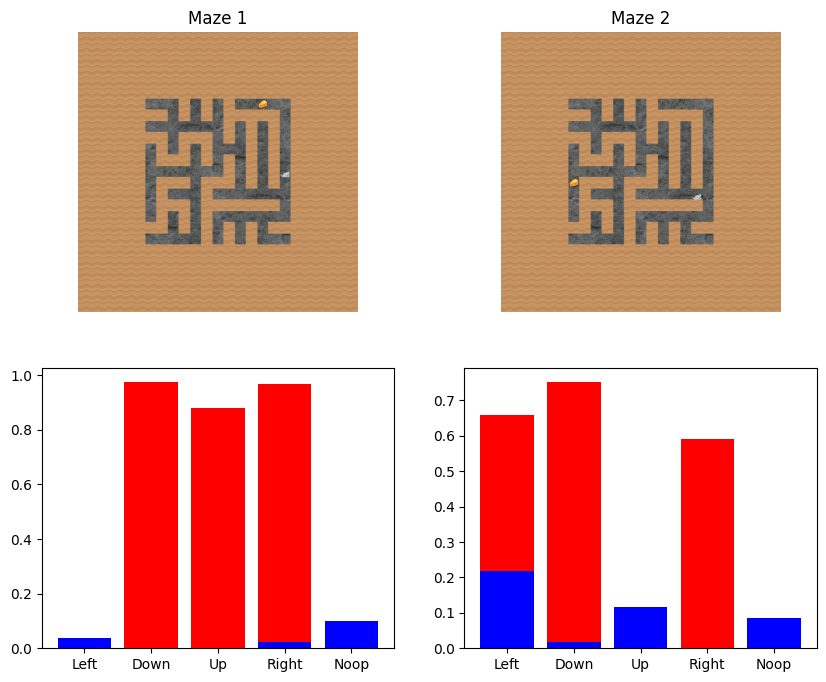

In [21]:
done = np.zeros(venv.num_envs)
obs = venv.reset()

fig, ax = plt.subplots(2, venv.num_envs, figsize=(10, 8))

# while not all(done): # run till both agents finish
for _ in range(10): # run for a few timesteps
    policy.eval()
    p, v = policy(torch.FloatTensor(obs))
    act = p.sample().numpy()
    #act = p.probs.argmax(dim=-1).numpy()
    obs, rew, done_now, info = venv.step(act)
    done = np.logical_or(done, done_now) # TODO: Don't keep running finished envs 

    if not all(done): # don't show last frame (new maze)
        # plt.imshow(obs[0].transpose(1,2,0)) # agent view
        for i in range(ax.shape[1]):
            ax[0, i].set_title(f'Maze {i+1}')
            ax[0, i].imshow(info[i]['rgb'])
            ax[0, i].axis('off')
            action_name_prob_dict = {k: v.detach().numpy() for k,v in models.cat_to_human(p).items()}
            x = np.arange(len(action_name_prob_dict.keys()))

            # FIXME: Colors display wrong
            act_name = next(k for k,v in models.MAZE_ACITON_INDEXES.items() if act[i] in v)
            colors = ['red' if act_name == k else 'blue' for k in action_name_prob_dict.keys()]
            # plot probs under graphs
            ax[1, i].bar(x, [v[i] for v in action_name_prob_dict.values()], color=colors)
            ax[1, i].set_xticks(x, [k.title() for k in action_name_prob_dict.keys()])

        display.display(fig)
        # display.clear_output(wait=True)

### Under the hood: Less magic venv manipulation

The `maze.EnvState` class wraps the `state_bytes` from a specific maze env. It has an array of helpers for manipulating mazes.

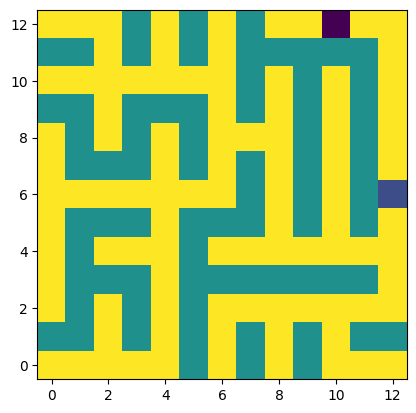

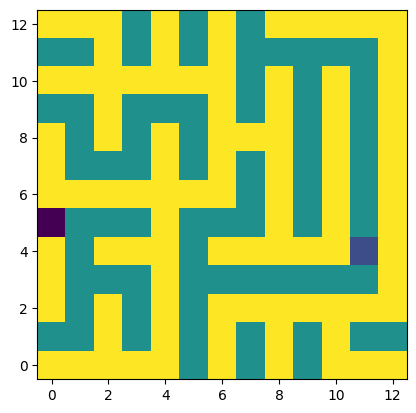

In [22]:
env_states = [maze.EnvState(sb) for sb in venv.env.callmethod("get_state")]
for es in env_states:
    plt.imshow(es.inner_grid(), origin='lower')
    plt.show()

#### Move the mouse to the top right

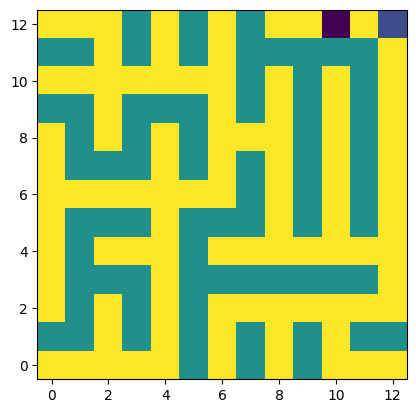

In [23]:
g = env_states[0].inner_grid()
x,y = maze.get_mouse_pos(g) # a trivial numpy helper
g[x, y] = maze.EMPTY
g[12,12] = maze.MOUSE
plt.imshow(g, origin='lower')

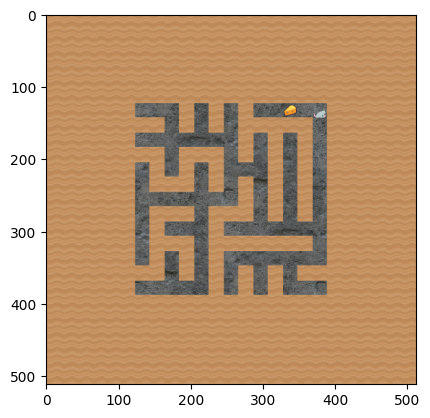

In [24]:
# Looks good! now to update the maze itself
env_states[0].set_grid(g, pad=True) # Update the EnvState. Pad=True to add walls around the maze
venv.env.callmethod("set_state", [s.state_bytes for s in env_states]) # Update the venv
plt.imshow(venv.env.get_info()[0]['rgb'])